In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from PIL import ImageFile
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
#setting the base directory for the dataset
base_dir = r'C:\Users\Neo\Documents\Wits\Honours\ACML\Project\BoneFracture\data'

In [3]:
#checking if cuda is available and device that will be used for training
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

print(f'Current device: {device}')


CUDA is available. Using GPU.
Current device: cuda


In [8]:

# Preprocessing
# Defining transformations
transform = transforms.Compose([
    #each image is set to be a fixed size of 256x256 pixels
    transforms.Resize((256, 256)),
    #formatting for PyTorch's expected format of images
    #changes colour values to lie in interval [0.0,1.0] instead of [0,255]
    transforms.ToTensor(),
    #normalisation to scale colour values
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("Loading dataset...")
# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'train'), transform=transform)
validation_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'validation'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=transform)
print("Dataset loaded!")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)  # Typically, we don't need to shuffle validation data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




Loading dataset...
Dataset loaded!


In [11]:
# Plotting
def plot_class_distribution(train_counts, validation_counts, test_counts):
    labels = list(train_counts.keys())
    train_values = list(train_counts.values())
    validation_values = list(validation_counts.values())
    test_values = list(test_counts.values())

    x = range(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, train_values, width, label='Train')
    rects2 = ax.bar([p + width for p in x], validation_values, width, label='Validation')
    rects3 = ax.bar([p + width * 2 for p in x], test_values, width, label='Test')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts')
    ax.set_title('Counts by dataset and class')
    ax.set_xticks([p + width for p in x])
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()

    plt.show()


C:\Users\Neo\anaconda3\envs\ACML\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


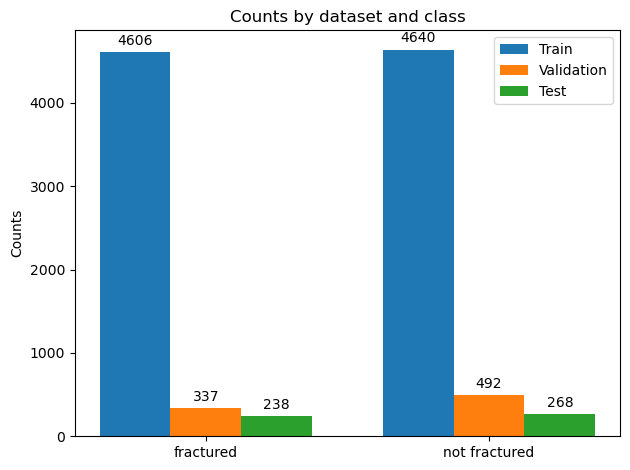

In [12]:
# Function to count samples per class
def count_samples(dataset):
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts


train_counts = count_samples(train_dataset)
validation_counts = count_samples(validation_dataset)
test_counts = count_samples(test_dataset)

# Call the plotting function
plot_class_distribution(train_counts, validation_counts, test_counts)

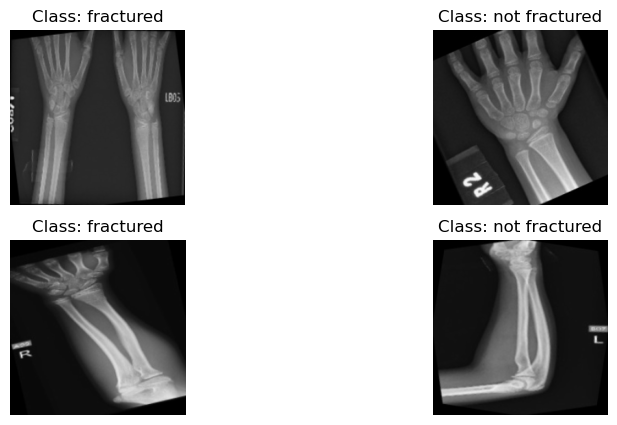

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_images(data_loader, num_samples=2):
    class_names = data_loader.dataset.classes
    figure, ax = plt.subplots(nrows=2, ncols=num_samples, figsize=(10, 5))
    class_sample_count = {class_name: 0 for class_name in class_names}

    # Go through batches of images and display samples for each class
    with torch.no_grad():
        for images, labels in data_loader:
            for image, label in zip(images, labels):
                class_name = class_names[label]
                if class_sample_count[class_name] < num_samples:
                    # Revert normalization and adjust channel order for display
                    image = image.numpy()  # Convert to numpy array
                    image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions to HxWxC
                    # Scale image data to [0, 1] if it was normalized with mean=0.5 and std=0.5
                    image = image * 0.5 + 0.5  # Adjust depending on your normalization
                    image = np.clip(image, 0, 1)  # Ensure values are within [0, 1] to avoid warnings

                    ax[class_sample_count[class_name], label].imshow(image)
                    ax[class_sample_count[class_name], label].set_title(f"Class: {class_name}")
                    ax[class_sample_count[class_name], label].axis("off")
                    class_sample_count[class_name] += 1
                    if all(count >= num_samples for count in class_sample_count.values()):
                        plt.show()
                        return

show_sample_images(train_loader)

In [7]:
class XRayCNN(nn.Module):
    def __init__(self):
        super(XRayCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(-1, 32 * 64 * 64)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return val_loss / len(data_loader), correct / total

# Training function with Early Stopping and Learning Rate Scheduler
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10, patience=3):
    print("starting training")
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss, val_accuracy = evaluate_model(model, val_loader, device)
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Stopping early due to increasing validation loss.")
            break


In [8]:
# Initialize model, criterion, optimizer, and scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = XRayCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Train the model
train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, device)

# Optionally load the best model and perform final testing
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_accuracy = evaluate_model(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

C:\Users\Neo\anaconda3\envs\ACML\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Loss: 0.6299, Val Loss: 0.3817, Val Accuracy: 0.8951
Epoch 2: Train Loss: 0.1064, Val Loss: 0.1932, Val Accuracy: 0.9361
Epoch 3: Train Loss: 0.0481, Val Loss: 0.7977, Val Accuracy: 0.7286
Epoch 4: Train Loss: 0.0210, Val Loss: 0.1217, Val Accuracy: 0.9614
Epoch 5: Train Loss: 0.0261, Val Loss: 0.0839, Val Accuracy: 0.9674
Epoch 6: Train Loss: 0.0176, Val Loss: 0.2162, Val Accuracy: 0.9674
Epoch 7: Train Loss: 0.0487, Val Loss: 0.1022, Val Accuracy: 0.9674
Epoch 8: Train Loss: 0.0329, Val Loss: 0.0784, Val Accuracy: 0.9686
Epoch 9: Train Loss: 0.0055, Val Loss: 0.0844, Val Accuracy: 0.9867
Epoch 10: Train Loss: 0.0076, Val Loss: 0.1151, Val Accuracy: 0.9795
Test Loss: 0.0532, Test Accuracy: 0.9704


In [19]:
test_model(model, test_loader, device)

Test Loss: 0.0036, Accuracy: 1.0000
